In [1]:
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import seaborn as sn
import utils

plt.style.use("ggplot")

In [2]:
eng = nivapy.da.connect()

Username:  ········
Password:  ········


Connection successful.


# ICPW Thematic report 2023

## Part A: Site selection

## 1. Get stations

In [3]:
# Get ICPW stations
xl_path = r"../../../all_icpw_sites_mar_2023.xlsx"
stn_df = pd.read_excel(xl_path, sheet_name="all_icpw_stns")
print(f"There are {len(stn_df)} stations in the ICPW project.")
display(stn_df.head())
nivapy.spatial.quickmap(stn_df, cluster=True, popup="station_code")

There are 577 stations in the ICPW project.


,station_id,station_code,nfc_code,station_name,latitude,longitude,altitude,continent,country,region,group
0,38810,AM_001,NaN,"Pambak river, 0.5 km above Khnkoyan village",40.839315,44.048911,NaN,Europe,Armenia,Armenia,Core
1,38811,AM_057,NaN,"Marmarik river, 0.5 km above Hankavan village",40.663605,44.466029,NaN,Europe,Armenia,Armenia,Core
2,38812,AM_080,NaN,"Vedi river, 0.5 km above Urtsadzor village",39.921174,44.819649,NaN,Europe,Armenia,Armenia,Core
3,38813,AM_083,NaN,"Arpa river, 0.5 km above Jermuk town",39.843045,45.686151,NaN,Europe,Armenia,Armenia,Core
4,38814,AM_089,NaN,"Meghri river, 0.5 km above Meghri town",38.915268,46.233703,NaN,Europe,Armenia,Armenia,Core


## 2. Get chemistry

### 2.1. Basic parameters

 * Assume LOD values are equal to the LOD.

In [4]:
# Specify time period of interest
st_dt = "1990-01-01"
end_dt = "2020-12-31"

# Specify RESA2 parameters of interest
params = ["SO4", "NO3-N", "NH4-N", "Cl", "Ca", "Mg", "Na", "K", "pH", "TOC"]

# Get available parameters
par_df = nivapy.da.select_resa_station_parameters(stn_df, st_dt, end_dt, eng)
par_df = par_df.query("parameter_name in @params")
par_df

130 parameters available for the selected stations and dates.


,parameter_id,parameter_name,unit
17,11,Ca,mg/l
22,7,Cl,mg/l
49,12,K,mg/l
61,13,Mg,mg/l
66,49,NH4-N,µg/l N
67,5,NO3-N,µg/l N
68,14,Na,mg/l
90,8,SO4,mg/l
100,6,TOC,mg C/l
128,1,pH,None


In [5]:
# Get data
wc_df, dup_df = nivapy.da.select_resa_water_chemistry(
    stn_df,
    par_df,
    st_dt,
    end_dt,
    eng,
    lod_flags=False,
    drop_dups=True,
)

# Only consider samples within 1 m of surface
wc_df = wc_df.query("depth2 < 1")
del wc_df["depth1"], wc_df["depth2"]

wc_df.head()

WARNING
The database contains unexpected duplicate values for some station-date-parameter combinations.
Only the most recent values will be used, but you should check the repeated values are not errors.
The duplicated entries are returned in a separate dataframe.



,station_id,station_code,station_name,sample_date,Ca_mg/l,Cl_mg/l,K_mg/l,Mg_mg/l,NH4-N_µg/l N,NO3-N_µg/l N,Na_mg/l,SO4_mg/l,TOC_mg C/l,pH_
,,,,,,,,,,,,,,
0,100,623-603,Breidlivatnet,1990-10-07,0.35,0.9,0.12,0.17,NaN,26.0,0.73,2.9,4.72,4.72
1,100,623-603,Breidlivatnet,1991-09-29,0.40,0.8,0.10,0.15,NaN,27.0,0.80,3.1,3.56,4.89
2,100,623-603,Breidlivatnet,1992-10-10,0.49,0.9,0.15,0.16,NaN,6.0,0.82,2.8,5.90,4.78
3,100,623-603,Breidlivatnet,1993-10-14,0.36,0.7,0.13,0.10,NaN,28.0,0.64,2.2,6.60,4.95
4,100,623-603,Breidlivatnet,1994-10-01,0.37,0.7,0.11,0.13,NaN,66.0,0.60,2.2,5.70,4.79


### 2.2. Derived parameters

Using the "basic" parameters above:

 * Convert to microequivalents per litre where relevant
 
 * Calculate (Ca + Mg) in ueq/l
 
 * Calculate [H+] from pH
 
 * Calculate SAA (sum of acid anions) as $(Cl + SO_4 + NO_3)$ (all expressed in ueq/l)
 
 * Calculate ANC as $(Ca + Mg + Na + K + NH_4) - (Cl + SO_4 + NO_3)$ (all expressed in ueq/l)
 
 * Calculate organic anions using the model of [Hruška et al. (2003)](https://doi.org/10.1021/es0201552)
 
 * Calculate bicarbonate from the ion balance as $ANC + H - OrgAnions$ (all expressed in ueq/l)
 
See the issue [here](https://github.com/JamesSample/icpw2/issues/3) for further details.

In [6]:
# Convert to ueq/l
ueq_cols = [
    "SO4_mg/l",
    "NO3-N_µg/l N",
    "NH4-N_µg/l N",
    "Cl_mg/l",
    "Ca_mg/l",
    "Mg_mg/l",
    "Na_mg/l",
    "K_mg/l",
]
for col in ueq_cols:
    wc_df = utils.convert_to_microequivalents(wc_df, col)

# Ca + Mg
wc_df["CaMg_µeq/l"] = wc_df["Ca_µeq/l"] + wc_df["Mg_µeq/l"]

# H+ from pH
wc_df["H_µeq/l"] = 1e6 * 10 ** -wc_df["pH_"]

# Calculate SAA
wc_df["SAA_µeq/l"] = wc_df["Cl_µeq/l"] + wc_df["SO4_µeq/l"] + wc_df["NO3-N_µeq/l"]

# Calculate ANC
wc_df = utils.calculate_anc(wc_df, anc_oaa=False)

# Organic anions. See
# https://github.com/JamesSample/icpw2/issues/4#issuecomment-1528806056
# for choice of 'site_density'
wc_df = utils.calculate_organic_anions(wc_df, site_density=16.6)

# HCO3
wc_df = utils.calculate_bicarbonate(wc_df)

## 3. Raw data distributions by country

For each parameter.

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:3201: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


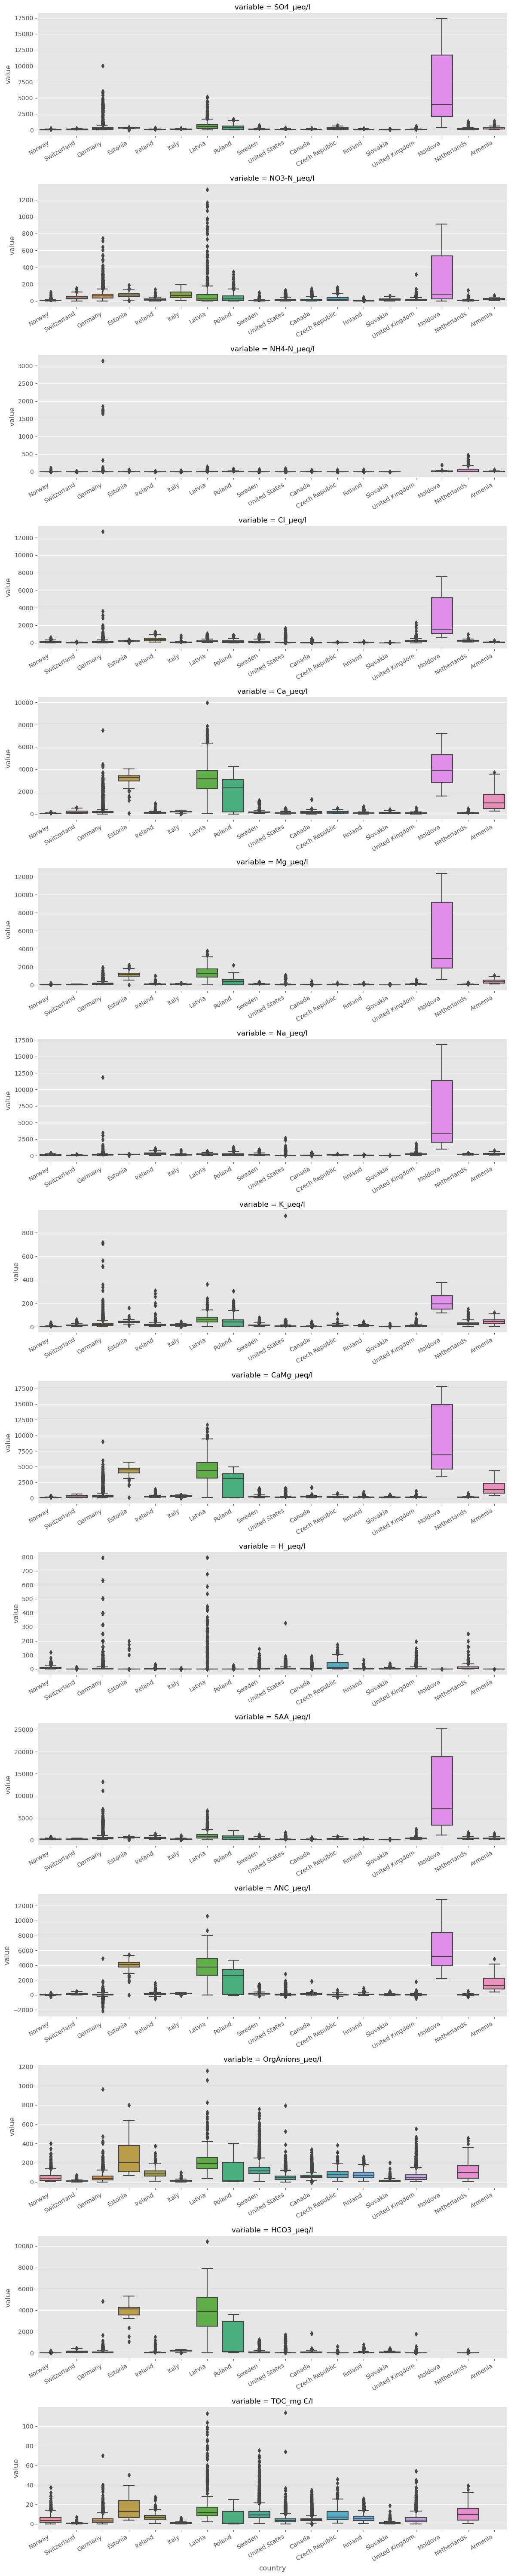

In [7]:
# Join country attribute
df = pd.merge(wc_df, stn_df[["station_id", "country"]], how="left", on="station_id")

# Pars to plot
pars = [col for col in df.columns if "eq/l" in col] + ["TOC_mg C/l"]

# Reshape
df = df[["country"] + pars]
df = df.melt(id_vars=["country"])

# Plot
g = sn.catplot(
    data=df,
    x="country",
    y="value",
    row="variable",
    kind="box",
    sharex=False,
    sharey=False,
    height=4,
    aspect=3,
)
g.set_xticklabels(rotation=30, ha="right")
plt.tight_layout()

## 4. Data cleaning

### 4.1. Filter stations and countries

Based on e-mail discussion with Rolf and Heleen 26.04.2023:

 * Remove data from Moldova (`MD01` and `MD02`), as we suspect these sites are affected by mining
 
 * Remove `DE04`, `DE09`, `DE14`, `DE15`, `DE21`, `DE25`, `DE30` and `DE31`, as we suspect they are also affected by mining and/or liming (see also e-mail from Rolf received 29.04.2023)
 
 * Remove data from Latvia and Estonia, due to very different geology

In [8]:
len1 = len(wc_df)
print(len1, "samples in the raw dataset.")

# Remove stations in Germany and Moldova affected by mining
wc_df = wc_df.query(
    "station_code not in ('MD01', 'MD02', 'DE04', 'DE09', 'DE14', 'DE15', 'DE21', 'DE25', 'DE30', 'DE31')"
)

# Latvia and Estonia have unusual geology and should be removed from
# this analysis. See e-mail from Heleen received 26.04.2023 at 10.26
exclude_list = stn_df.query("country in ('Latvia', 'Estonia')")["station_code"].tolist()
wc_df = wc_df.query("station_code not in @exclude_list")

len2 = len(wc_df)
print(len1 - len2, "samples excluded.")
print(len2, "samples remain.")

98365 samples in the raw dataset.
2606 samples excluded.
95759 samples remain.


### 4.2. Filter outliers

The code below uses a simple approach to remove outliers based on the "double MAD" method (see e.g. [here](http://eurekastatistics.com/using-the-median-absolute-deviation-to-find-outliers/)). Note that this method does not account for autocorrelation in the series, as it just considers the values not the temporal order. It is also not good at detecting step-changes where there are plenty of values either side of the "step".

In general, I prefer to use robust statistics to reduce the influence of outliers at the analysis stage, rather than filtering them out of the dataset *a priori*. I have therefore set a **conservative threshold** for removing outliers in the code below: a typical value would be `thresh=3.5`, whereas I have used `thresh=5`. My code will therefore only filter out the most extreme outliers.

In [9]:
# Reshape to 'long'
id_cols = ["station_id", "station_code", "station_name", "sample_date"]
pars = [col for col in wc_df.columns if "eq/l" in col] + ["TOC_mg C/l"]
df = wc_df[id_cols + pars].copy()
df = df.melt(id_vars=id_cols, var_name="parameter").dropna()

# Test each series for outliers
df_list = []
stn_list = df["station_id"].unique().tolist()

for stn_id in stn_list:
    for par in pars:
        stn_par_df = df.query("(station_id == @stn_id) and (parameter == @par)").copy()
        if len(stn_par_df) > 0:
            stn_par_df["outlier"] = utils.double_mad_from_median(
                stn_par_df["value"], thresh=5
            )
            df_list.append(stn_par_df)
df = pd.concat(df_list)
df.head()

,station_id,station_code,station_name,sample_date,parameter,value,outlier
0,100,623-603,Breidlivatnet,1990-10-07,SO4_µeq/l,60.377924,False
1,100,623-603,Breidlivatnet,1991-09-29,SO4_µeq/l,64.541919,False
2,100,623-603,Breidlivatnet,1992-10-10,SO4_µeq/l,58.295927,False
3,100,623-603,Breidlivatnet,1993-10-14,SO4_µeq/l,45.803942,False
4,100,623-603,Breidlivatnet,1994-10-01,SO4_µeq/l,45.803942,False


As a sense check, the code below selects 9 series with outliers at random from the dataset and shows the time series, with outliers identified in red.

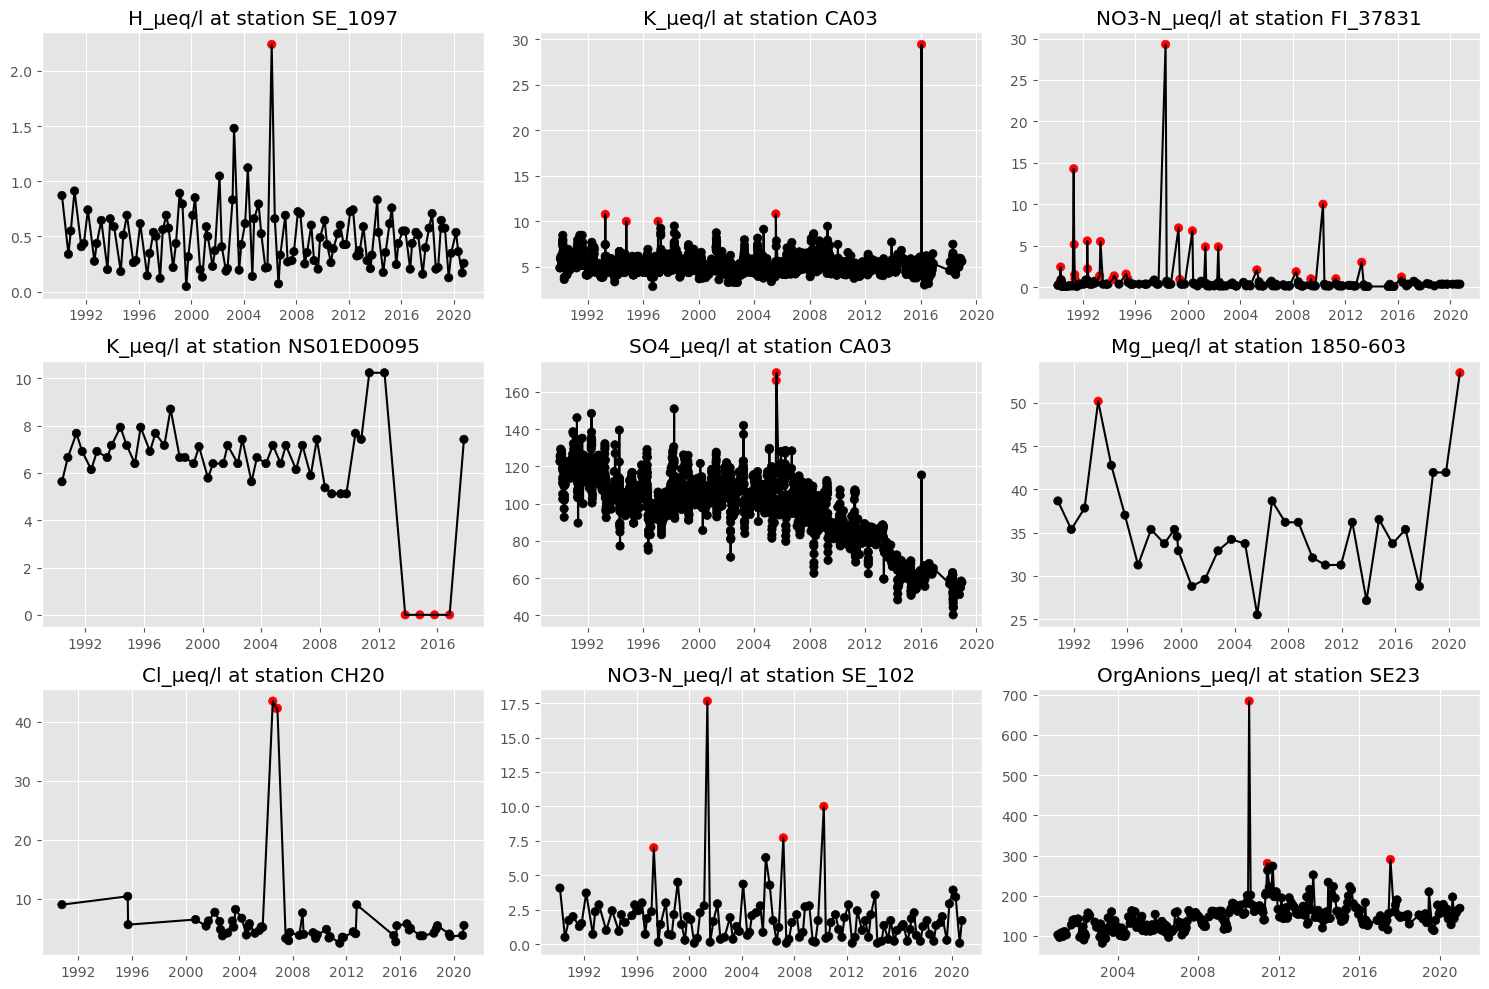

In [10]:
# Randomly sample series with outliers to check the filtering is reasonable
rand_df = (
    df.query("outlier == True")[["station_id", "station_code", "parameter"]]
    .drop_duplicates()
    .sample(n=9)
    .reset_index(drop=True)
    .copy()
)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.flatten()
for idx, row in rand_df.iterrows():
    stn_id = row["station_id"]
    stn_code = row["station_code"]
    par = row["parameter"]
    data_df = df.query("(station_id == @stn_id) and (parameter == @par)").copy()
    data_df.sort_values("sample_date", inplace=True)
    data_df["outlier_col"] = ["r" if i else "k" for i in data_df["outlier"]]
    axes[idx].plot(data_df["sample_date"], data_df["value"], "k-")
    axes[idx].scatter(
        data_df["sample_date"], data_df["value"], c=data_df["outlier_col"].tolist()
    )
    axes[idx].set_title(f"{par} at station {stn_code}")
plt.tight_layout()

In [11]:
# Remove outliers and reshape to 'wide'
df = df.query("outlier == False")
del df["outlier"]
df = df.groupby(id_cols + ["parameter"]).mean().reset_index()
wc_df = df.pivot(columns="parameter", index=id_cols, values="value").reset_index()
wc_df.dropna(subset=pars, how="all", inplace=True)
wc_df.columns.name = ""

print(len(wc_df), "samples remain after filtering outliers.")

95747 samples remain after filtering outliers.


### 4.3. Ion balance

In a comment [here](https://github.com/JamesSample/icpw2/issues/4#issuecomment-1522126141), Rolf suggested calculating the ion balance and discarding samples where the difference is >20%. However, we have already calculated bicarbonate using the ion balance ([here](https://github.com/JamesSample/icpw2/issues/3#issuecomment-1521604595)), so the ion balance in this dataset is by definition zero, *except in cases where the estimate for HCO3 is initially negative* (in which case it is [set back to zero](https://github.com/JamesSample/icpw2/blob/e0192bc439618ed9d3c10c7adbc1d28836c6a456/thematic_report_2023/utils.py#L477)). See the comment [here](https://github.com/JamesSample/icpw2/issues/4#issuecomment-1523093566) for further discussion of this.

The code below estimates the ion balance as

$$IB = Ca + Mg + Na + K + HN4 + H - Cl - SO4 - NO3 - OrgAnions - HCO3$$

and discards samples where the difference is greater than 20% of the summed cations. Note that because of the way we have calculated HCO3, this corresponds to samples where the initial HCO3 estimate was strongly negative.

**Note:** After further discussion, we have decided not to use this method.

In [12]:
# # Filter samples based on ion balance
# for par in ["NH4-N_µeq/l", "K_µeq/l"]:
#     if par in wc_df.columns:
#         wc_df[par + "_temp"] = wc_df[par].fillna(0)
#     else:
#         wc_df[par + "_temp"] = 0

# wc_df["Cations_µeq/l"] = (
#     wc_df["Ca_µeq/l"]
#     + wc_df["Mg_µeq/l"]
#     + wc_df["Na_µeq/l"]
#     + wc_df["K_µeq/l_temp"]
#     + wc_df["NH4-N_µeq/l_temp"]
#     + wc_df["H_µeq/l"]
# )
# wc_df["Anions_µeq/l"] = (
#     wc_df["Cl_µeq/l"]
#     + wc_df["SO4_µeq/l"]
#     + wc_df["NO3-N_µeq/l"]
#     + wc_df["OrgAnions_µeq/l"]
#     + wc_df["HCO3_µeq/l"]
# )

# wc_df["IonBal_µeq/l"] = wc_df["Cations_µeq/l"] - wc_df["Anions_µeq/l"]
# wc_df["Zdiff_pct"] = 100 * wc_df["IonBal_µeq/l"] / wc_df["Cations_µeq/l"]
# del wc_df["K_µeq/l_temp"], wc_df["NH4-N_µeq/l_temp"]

# print("Total number of water samples:", len(wc_df))
# print(
#     "Number for which ion balance cannot be calculated:",
#     len(wc_df[pd.isna(wc_df["Zdiff_pct"])]),
# )
# print(
#     "Number with ion balance difference >20%", len(wc_df[wc_df["Zdiff_pct"].abs() > 20])
# )
# print(
#     "Number with ion balance difference ≤20%",
#     len(wc_df[wc_df["Zdiff_pct"].abs() <= 20]),
# )

# # Remove data with suspicious ion balance
# wc_df = wc_df[wc_df["Zdiff_pct"].abs() <= 20]
# del (
#     wc_df["Cations_µeq/l"],
#     wc_df["Anions_µeq/l"],
#     wc_df["IonBal_µeq/l"],
#     wc_df["Zdiff_pct"],
# )

# print("Number of samples remaining:", len(wc_df))

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:3201: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


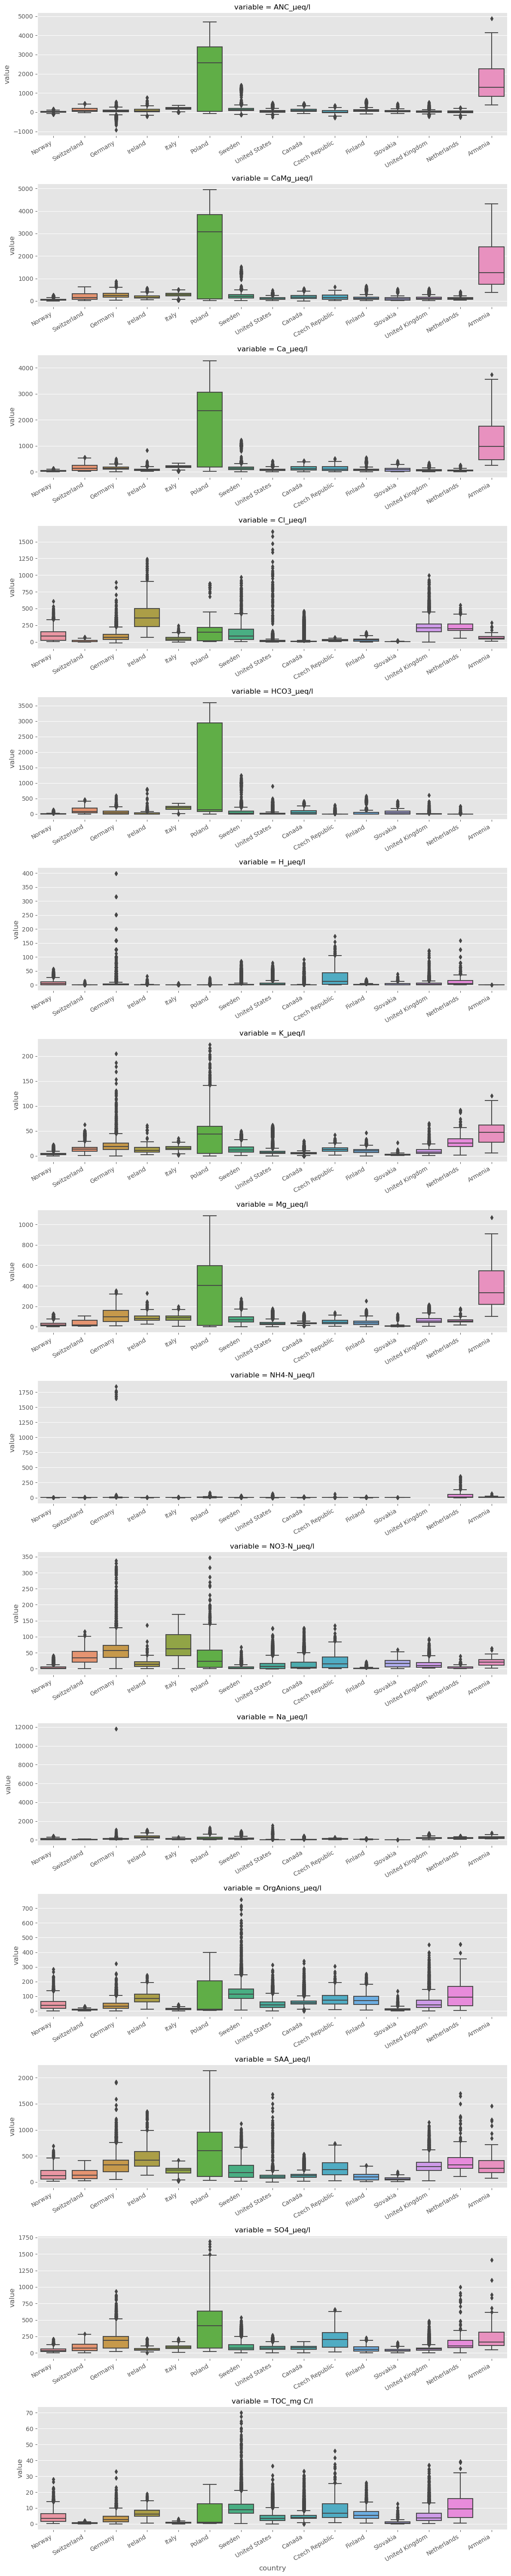

In [13]:
# Updated distribution plots
# Join country attribute
df = pd.merge(wc_df, stn_df[["station_id", "country"]], how="left", on="station_id")

# Pars to plot
pars = [col for col in df.columns if "eq/l" in col] + ["TOC_mg C/l"]

# Reshape
df = df[["country"] + pars]
df = df.melt(id_vars=["country"])

# Plot
g = sn.catplot(
    data=df,
    x="country",
    y="value",
    row="variable",
    kind="box",
    sharex=False,
    sharey=False,
    height=4,
    aspect=3,
)
g.set_xticklabels(rotation=30, ha="right")
plt.tight_layout()

In [14]:
# Save for speed later
csv_path = r"./data/thematic_report_2023_working_data.csv"
wc_df.to_csv(csv_path, index=False, encoding="utf-8")

## 5. Aggregate to annual medians

In [15]:
# Read saved data
csv_path = r"./data/thematic_report_2023_working_data.csv"
wc_df = pd.read_csv(csv_path, encoding="utf-8")
wc_df["sample_date"] = pd.to_datetime(wc_df["sample_date"], format="%Y-%m-%d")

# Annual medians by station
wc_df["year"] = wc_df["sample_date"].dt.year
ann_df = wc_df.groupby(["station_id", "year"]).median().reset_index()
ann_df.head()

/tmp/ipykernel_4236/1831508253.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ann_df = wc_df.groupby(["station_id", "year"]).median().reset_index()


,station_id,year,ANC_µeq/l,CaMg_µeq/l,Ca_µeq/l,Cl_µeq/l,HCO3_µeq/l,H_µeq/l,K_µeq/l,Mg_µeq/l,NH4-N_µeq/l,NO3-N_µeq/l,Na_µeq/l,OrgAnions_µeq/l,SAA_µeq/l,SO4_µeq/l,TOC_mg C/l
0,100,1990,-21.348747,31.449933,17.465070,25.385722,0.0,19.054607,3.068897,13.984863,NaN,1.857143,31.753212,43.455418,87.620789,60.377924,4.72
1,100,1991,-19.380456,32.299665,19.960080,22.565086,0.0,12.882496,2.557414,12.339585,NaN,1.928571,34.798041,34.571964,89.035577,64.541919,3.56
2,100,1992,-6.992785,37.613322,24.451098,25.385722,0.0,16.595869,3.836121,13.162224,NaN,0.428571,35.667992,55.422334,84.110220,58.295927,5.90
3,100,1993,-10.194860,26.190462,17.964072,19.744450,0.0,11.220185,3.324638,8.226390,NaN,2.000000,27.838433,65.145349,67.548393,45.803942,6.60
4,100,1994,-12.193611,29.157381,18.463074,19.744450,0.0,16.218101,2.813155,10.694307,NaN,4.714286,26.098531,53.715948,70.262679,45.803942,5.70


## 6. Site selection

In [16]:
# Pars to consider
df = ann_df.copy()
pars = [col for col in df.columns if "eq/l" in col] + ["TOC_mg C/l"]
df = df[["station_id", "year"] + pars]

# Melt to long format
df = pd.melt(df, id_vars=["station_id", "year"])
df.dropna(how="any", inplace=True)
df.head()

,station_id,year,variable,value
0,100,1990,ANC_µeq/l,-21.348747
1,100,1991,ANC_µeq/l,-19.380456
2,100,1992,ANC_µeq/l,-6.992785
3,100,1993,ANC_µeq/l,-10.194860
4,100,1994,ANC_µeq/l,-12.193611


In [17]:
# Define selection criteria
n_start_thresh = 1  # Number of annual values in first 5 years
n_end_thresh = 1  # Number of annual values in last 5 years
prop_thresh = 0.65  # Proportion of total years with data
periods = ((1990, 2020), (1990, 2004), (1998, 2012), (2006, 2020))

# Dict for results
inc_dict = {
    "station_id": [],
    "variable": [],
    "period": [],
    "include": [],
}

# Loop over time series
for stn_id in df["station_id"].unique():
    # Loop over variables
    for par in df["variable"].unique():
        # Get data
        stn_par_df = df.query("(station_id == @stn_id) and (variable == @par)")
        stn_par_df.set_index("year", inplace=True)
        del stn_par_df["station_id"], stn_par_df["variable"]

        for period in periods:
            st_yr, end_yr = period
            years = range(st_yr, end_yr + 1)
            n_yrs = len(years)
            yrs_thresh = round(n_yrs * prop_thresh)
            years_df = pd.DataFrame(index=years)

            # Join by year (=> annual series with no gaps)
            stn_par_yr_df = years_df.join(stn_par_df)

            if pd.isna(stn_par_yr_df["value"]).all().all():
                # Not suitable
                inc_dict["station_id"].append(stn_id)
                inc_dict["variable"].append(par)
                inc_dict["period"].append(f"{st_yr}-{end_yr}")
                inc_dict["include"].append(0)

            else:
                n_start = pd.notnull(
                    stn_par_yr_df[stn_par_yr_df.index < (st_yr + 5)]["value"]
                ).sum()
                n_end = pd.notnull(
                    stn_par_yr_df[stn_par_yr_df.index > (end_yr - 5)]["value"]
                ).sum()
                non_missing = pd.notnull(stn_par_yr_df["value"]).sum()

                if (
                    (n_start >= n_start_thresh)
                    and (n_end >= n_end_thresh)
                    and (non_missing >= yrs_thresh)
                ):
                    # Include
                    inc_dict["station_id"].append(stn_id)
                    inc_dict["variable"].append(par)
                    inc_dict["period"].append(f"{st_yr}-{end_yr}")
                    inc_dict["include"].append(1)

                else:
                    # Not suitable
                    inc_dict["station_id"].append(stn_id)
                    inc_dict["variable"].append(par)
                    inc_dict["period"].append(f"{st_yr}-{end_yr}")
                    inc_dict["include"].append(0)

# Build df
inc_df = pd.DataFrame(inc_dict)

# Unstack to 'wide'
inc_df.set_index(["station_id", "variable", "period"], inplace=True)
inc_df = inc_df.unstack("variable")
inc_df.columns = inc_df.columns.get_level_values(1)
inc_df.reset_index(inplace=True)

# Join station details
inc_df = pd.merge(
    inc_df,
    stn_df[["station_id", "station_code", "station_name", "country"]],
    how="left",
    on="station_id",
)

inc_df.to_csv("./data/selection_criteria_by_station-par-period.csv", index=False)

## 7. Output raw data for each period

Rolf would like two versions of the raw data: one where the **number of sites varies between periods** and another where it **remains fixed** (see e-mail received 16.05.2023 at 14.25).

In [18]:
# Parameters of interest for analysis
par_list = [
    "SO4_µeq/l",
    "NO3-N_µeq/l",
    # "NH4-N_µeq/l",
    "Cl_µeq/l",
    "Ca_µeq/l",
    "Mg_µeq/l",
    "CaMg_µeq/l",
    "H_µeq/l",
    "SAA_µeq/l",
    "ANC_µeq/l",
    "OrgAnions_µeq/l",
    "HCO3_µeq/l",
    "TOC_mg C/l",
]

# Periods to consider
periods = ((1990, 2020), (1990, 2004), (1998, 2012), (2006, 2020))

In [19]:
# Station propertiess
xl_path = r"../../../all_icpw_sites_mar_2023.xlsx"
stn_df = pd.read_excel(xl_path, sheet_name="all_icpw_stns")

# Median annual chemistry
csv_path = r"./data/thematic_report_2023_working_data.csv"
wc_df = pd.read_csv(csv_path, encoding="utf-8")
wc_df["sample_date"] = pd.to_datetime(wc_df["sample_date"], format="%Y-%m-%d")
wc_df["year"] = wc_df["sample_date"].dt.year
# wc_df = wc_df.groupby(["station_id", "year"]).median().reset_index()
wc_df = wc_df[["station_id", "station_code", "station_name", "sample_date", "year"] + par_list]

# Selection criteria
csv_path = r"./data/selection_criteria_by_station-par-period.csv"
inc_df = pd.read_csv(csv_path, encoding="utf-8")
inc_df = inc_df[["station_id", "period"] + par_list]
# del inc_df["NH4-N_µeq/l"] # Don't care about NH4 for site selection - see above
inc_df.set_index(["station_id", "period"], inplace=True)
inc_df[inc_df == 0] = np.nan
inc_df.dropna(how="any", inplace=True)
inc_df.reset_index(inplace=True)

In [20]:
for vary_sites in (True, False):
    if vary_sites:
        xl_path = r"./data/cleaned_icpw_data_vary_nsites.xlsx"
    else:
        xl_path = r"./data/cleaned_icpw_data_fixed_nsites.xlsx"

    with pd.ExcelWriter(xl_path) as writer:
        # Get station list if nsites is fixed
        stn_list = (
            inc_df.groupby(["station_id"])[["period"]]
            .count()
            .query("period == 4")
            .index.tolist()
        )
        for period in periods:
            st_yr, end_yr = period

            # Allow sites list to change by period, if desired
            if vary_sites:
                inc_df_per = inc_df.query(f"period == '{st_yr}-{end_yr}'").copy()
                stn_list = list(inc_df_per["station_id"].unique())

            # Get data that meet selection criteria for all parameters of interest
            df_per = wc_df.query(
                "(station_id in @stn_list) and (@st_yr <= year <= @end_yr)"
            ).copy()

            # Save to Excel
            df_per.to_excel(writer, sheet_name=f"{st_yr}-{end_yr}", index=False)